<a href="https://colab.research.google.com/github/cnosike15/CS4501-Project1/blob/main/Project1Nosike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Chrome History

In [13]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import pytz
from bs4 import BeautifulSoup
from dateutil import parser
import numpy as np
import re



In [14]:
import os

file_path = "History.json"

print(os.path.exists(file_path))


True


In [25]:
# Load Chrome history from Google Takeout
file_path = "History.json"

with open(file_path, "r") as file:
    data = json.load(file)

In [37]:

history = [
    {
        "datetime_utc": datetime.utcfromtimestamp(entry["time_usec"] / 1e6).replace(tzinfo=timezone.utc),
        "title": entry.get("title", "No Title"),
        "url": entry["url"],
        "client_id": entry.get("client_id", "Unknown Client"),
        "time_usec": entry["time_usec"]
    }
    for entry in data["Browser History"]
]

df = pd.DataFrame(history)

# Convert UTC to Eastern Time using .apply()
eastern = pytz.timezone("US/Eastern")
df["datetime_ET"] = df["datetime_utc"].apply(lambda x: x.astimezone(eastern))
df["date_only"] = df["datetime_ET"].dt.date
df["hour_of_day"] = df["datetime_ET"].dt.hour

# Function to convert time for start and end tracking
def convert_time(time_usec):
    utc_time = datetime.utcfromtimestamp(time_usec / 1e6).replace(tzinfo=timezone.utc)
    return utc_time.astimezone(eastern)

# Apply to create "Timestamp" column
df["Timestamp"] = df["time_usec"].apply(convert_time)

# Get browsing history start and end times
start_date = datetime(2025, 1, 13, 0, 0, 0, tzinfo=eastern)
end_date = datetime(2025, 2, 12, 23, 59, 59, tzinfo=eastern)
df = df[(df["datetime_ET"] >= start_date) & (df["datetime_ET"] <= end_date)]

# Print formatted start and end times
print(f"Start: {start_date.strftime('%A, %B %d, %Y %I:%M %p')}")
print(f"End: {end_date.strftime('%A, %B %d, %Y %I:%M %p')}")

# Calculate time differences to track activity gaps
df.sort_values("datetime_ET", inplace=True)
df["time_gap_hours"] = df["datetime_ET"].diff().dt.total_seconds() / 3600

# Detect browsing sessions (gaps >30 min indicate a new session)
session_gap = 0.5  # 30 minutes
df["new_session"] = df["time_gap_hours"] > session_gap
df["session_id"] = df["new_session"].cumsum()

# Get session start & end times
sessions = df.groupby("session_id").agg(
    start_time=("datetime_ET", "first"),
    end_time=("datetime_ET", "last"),
    duration=("time_gap_hours", "sum"),
    total_sites_visited=("url", "count")
).reset_index()

# Print browsing sessions
print("Browsing Sessions:")
print(sessions)


Start: Monday, January 13, 2025 12:00 AM
End: Wednesday, February 12, 2025 11:59 PM
Browsing Sessions:
     session_id                       start_time  \
0             0 2025-01-13 07:53:36.364808-05:00   
1             1 2025-01-13 09:00:00.303750-05:00   
2             2 2025-01-13 14:33:55.760936-05:00   
3             3 2025-01-13 16:53:50.729469-05:00   
4             4 2025-01-13 19:17:22.230963-05:00   
..          ...                              ...   
137         137 2025-02-12 13:06:39.011553-05:00   
138         138 2025-02-12 13:53:04.382187-05:00   
139         139 2025-02-12 16:18:41.050908-05:00   
140         140 2025-02-12 21:20:49.054500-05:00   
141         141 2025-02-12 22:20:03.166477-05:00   

                            end_time   duration  total_sites_visited  
0   2025-01-13 08:08:40.020955-05:00   0.251016                   57  
1   2025-01-13 10:20:19.094519-05:00   2.194187                  210  
2   2025-01-13 15:08:24.368656-05:00   4.801465            

<ipython-input-37-689b83990034>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values("datetime_ET", inplace=True)
<ipython-input-37-689b83990034>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time_gap_hours"] = df["datetime_ET"].diff().dt.total_seconds() / 3600
<ipython-input-37-689b83990034>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [38]:
#number of browsing events at each hour
print(df["hour_of_day"].value_counts().sort_index())


hour_of_day
0       31
1        1
5        8
6        9
7       22
8      156
9      618
10     834
11     949
12    1175
13    1031
14    1270
15    1079
16    1573
17     659
18     945
19    1208
20    1249
21     833
22     458
23      80
Name: count, dtype: int64


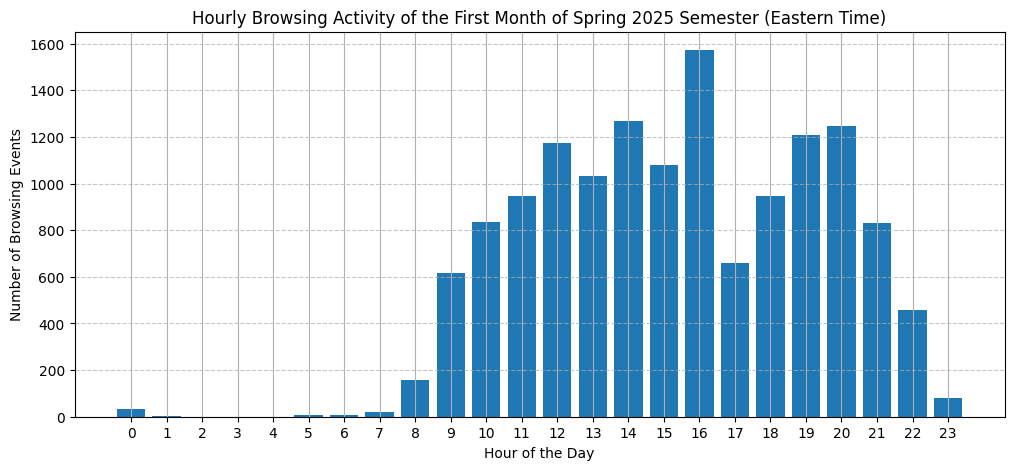

In [39]:

# Plot activity by hour
plt.figure(figsize=(12, 5))
df["hour_of_day"].hist(bins=range(25), rwidth=0.8, align='left')
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Browsing Events")
plt.title("Hourly Browsing Activity of the First Month of Spring 2025 Semester (Eastern Time)")
plt.xticks(range(24))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#Convert time to Eastern time

Youtube History

In [8]:
# Open and parse the watch-history.html file
with open('watch-history.html', 'r', encoding='utf-8') as f:
    soup = BeautifulSoup(f, 'html.parser')

/usr/local/lib/python3.11/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


Filtered YouTube history:


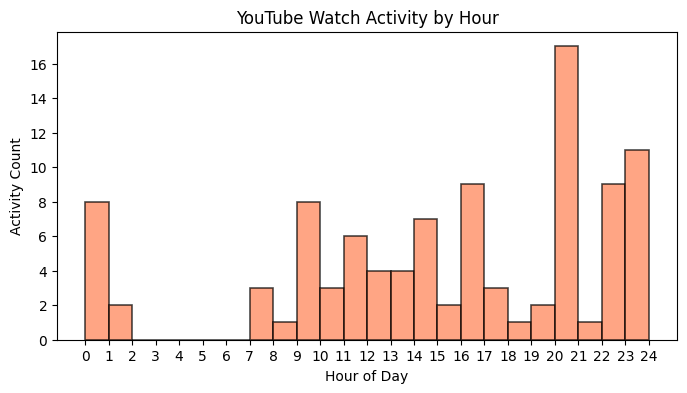

In [21]:

yt_entries = []

for div in soup.find_all('div', class_='content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1'):
    text = div.get_text(separator=" ", strip=True)

    # Normalize spaces
    text = text.replace('\u202f', ' ')

    # Use regex to extract timestamp (Supports different month formats)
    match = re.search(r'([A-Za-z]+ \d{1,2}, \d{4}, \d{1,2}:\d{2}:\d{2} (AM|PM) \w+)', text)

    if match:
        raw_str = match.group(1)
        try:
            dt = parser.parse(raw_str)  # Convert string to datetime object
            yt_entries.append({"datetime": dt, "text": text})
        except Exception:
            pass  # Skip if parsing fails

# Convert to DataFrame
youtube_df = pd.DataFrame(yt_entries)

# **Filter for January 13, 2025 - February 12, 2025**
start_date = pd.to_datetime("2025-01-13")
end_date = pd.to_datetime("2025-02-12 23:59:59")

youtube_df = youtube_df[(youtube_df['datetime'] >= start_date) & (youtube_df['datetime'] <= end_date)]

# **Check if data exists in the range**
if youtube_df.empty:
    print("No YouTube watch history found in the given date range.")
else:
    print("Filtered YouTube history:")


    # **Plot Watch Activity by Hour**
    youtube_df['hour'] = youtube_df['datetime'].dt.hour

    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(8, 4))
    plt.hist(
        youtube_df['hour'],
        bins=24,
        range=(0, 24),
        alpha=0.7,
        color='coral',
        edgecolor='black',
        linewidth=1.2
    )
    plt.xlabel('Hour of Day')
    plt.ylabel('Activity Count')
    plt.title('YouTube Watch Activity by Hour')

    plt.xticks(range(0, 25))  # Ensure x-axis shows hours 0-24
    plt.show()














In [40]:
#number of videos watched at each hour
print(youtube_df["hour"].value_counts().sort_index())


hour
0      8
1      2
7      3
8      1
9      8
10     3
11     6
12     4
13     4
14     7
15     2
16     9
17     3
18     1
19     2
20    17
21     1
22     9
23    11
Name: count, dtype: int64


Side-by-Side comparisons between Google History and Youtube History

/usr/local/lib/python3.11/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


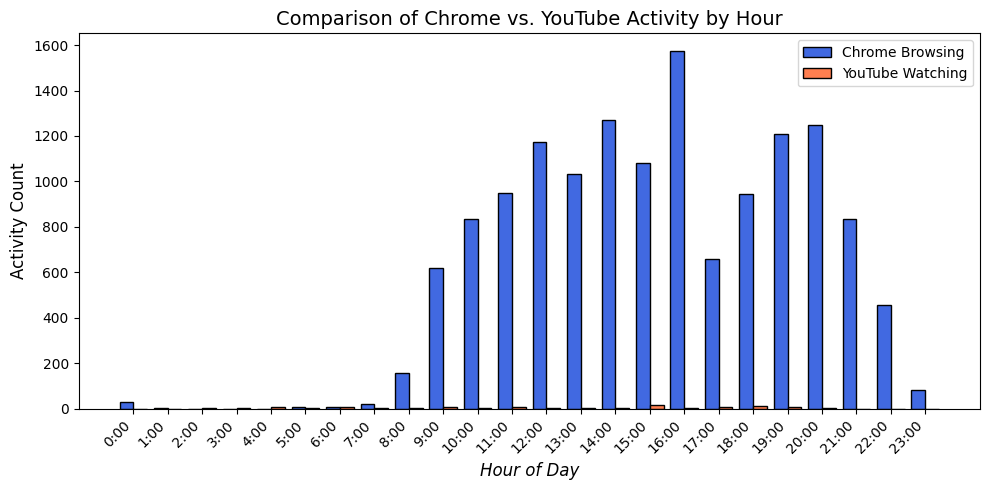

In [41]:
# === CHROME HISTORY PROCESSING ===
file_path = "History.json"

with open(file_path, "r") as file:
    data = json.load(file)

eastern = pytz.timezone("US/Eastern")

history = [
    {
        "datetime_utc": datetime.utcfromtimestamp(entry["time_usec"] / 1e6).replace(tzinfo=timezone.utc),
        "title": entry.get("title", "No Title"),
        "url": entry["url"],
        "time_usec": entry["time_usec"]
    }
    for entry in data["Browser History"]
]

df_chrome = pd.DataFrame(history)

# Convert UTC to Eastern Time
df_chrome["datetime_ET"] = df_chrome["datetime_utc"].apply(lambda x: x.astimezone(eastern))
df_chrome["hour_of_day"] = df_chrome["datetime_ET"].dt.hour

# Filter for January 13, 2025 - February 12, 2025
start_date = datetime(2025, 1, 13,  0, 0, 0, tzinfo=eastern)
end_date = datetime(2025, 2, 12, 23, 59, 59, tzinfo=eastern)

df_chrome = df_chrome[(df_chrome["datetime_ET"] >= start_date) & (df_chrome["datetime_ET"] <= end_date)]

# === YOUTUBE HISTORY PROCESSING ===
with open("watch-history.html", "r", encoding="utf-8") as f:
    soup = BeautifulSoup(f, "html.parser")

yt_entries = []

for div in soup.find_all("div", class_="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1"):
    text = div.get_text(separator=" ", strip=True)
    text = text.replace("\u202f", " ")  # Normalize spaces

    match = re.search(r"([A-Za-z]+ \d{1,2}, \d{4}, \d{1,2}:\d{2}:\d{2} (AM|PM) \w+)", text)

    if match:
        raw_str = match.group(1)
        try:
            dt = parser.parse(raw_str)
            yt_entries.append(dt)
        except Exception:
            pass  # Skip invalid timestamps

df_youtube = pd.DataFrame(yt_entries, columns=["datetime"])

# Make df_youtube "datetime" column tz-aware (Eastern time)
df_youtube["datetime"] = df_youtube["datetime"].dt.tz_localize("UTC").dt.tz_convert(eastern)

# Filter for the same date range
df_youtube = df_youtube[(df_youtube["datetime"] >= start_date) & (df_youtube["datetime"] <= end_date)]
df_youtube["hour"] = df_youtube["datetime"].dt.hour

# === PLOTTING COMPARISON IN ONE GRAPH ==
# Bin edges (24 hours)
bins = np.arange(0, 25)  # 0 to 24 (hour of day)

# Compute histogram values for each dataset
chrome_counts, _ = np.histogram(df_chrome["hour_of_day"], bins=bins)
youtube_counts, _ = np.histogram(df_youtube["hour"], bins=bins)

# Create labels for each hour
hours = np.arange(24)  # X positions for 24-hour range
categories = [f"{h}:00" for h in hours]  # Label hours as "0:00", "1:00", ...

# Set width for side-by-side bars
bar_width = 0.4

# Create figure
plt.figure(figsize=(10, 5))

# Plot Chrome Browsing data
plt.bar(hours - bar_width/2, chrome_counts, width=bar_width, color="royalblue", edgecolor="black", label="Chrome Browsing")

# Plot YouTube Watching data
plt.bar(hours + bar_width/2, youtube_counts, width=bar_width, color="coral", edgecolor="black", label="YouTube Watching")

# X-axis formatting
plt.xticks(hours, categories, rotation=45, ha="right")  # Rotate labels for clarity
plt.xlabel("Hour of Day", fontsize=12, fontstyle='italic')
plt.ylabel("Activity Count", fontsize=12)
plt.title("Comparison of Chrome vs. YouTube Activity by Hour", fontsize=14)

# Add legend
plt.legend()

# Improve layout
plt.tight_layout()

# Show plot
plt.show()














